In [1]:
from IPython.display import Audio
import torch
import os
from scipy.io import wavfile
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch
import torch.nn as nn

# Play the .wav file
Audio("digits_multiple/659.wav")

In [2]:
#!ls | grep .wav
#Audio('ssc_trial_1_000_pred_wav_2024-09-24.wav')
#Audio('ssc_trial_1_0135_pred_wav_2024-09-24.wav')
Audio('ssc_trial_1_000000_pred_wav_2024-09-24.wav')
#Audio('ssc_trial_1_0150_pred_wav_2024-09-24.wav')

In [3]:
import torch
import torch.nn as nn

class SwissArmyLayer(nn.Module):

    def __init__(self, t_seq_bits
                 , t_layer_dim
                 , t_num_layers
                 , num_layers
                 , one_hot_vocab_len = None #include padding
                 , one_hot_embedding_dim = None
                 , input_embedding_dim = None
                 ):
        super(SwissArmyLayer, self).__init__()

        if t_num_layers > 0:
            self.t_layers = nn.ModuleList()
            self.t_layers.append(nn.Linear(t_seq_bits, t_layer_dim))  # First layer: t_bits x t_bits_hidden
            for _ in range(t_num_layers - 1):
                self.t_layers.append(nn.Linear(t_layer_dim, t_layer_dim)) 
        else:
            #t_seq_bits is zero, so set t_layer_dim
            t_layer_dim = t_seq_bits
            
        hidden_dim = t_layer_dim

        
        if input_embedding_dim is not None:
            hidden_dim = hidden_dim + input_embedding_dim 
          
        
        if one_hot_vocab_len is not None and one_hot_embedding_dim is not None:
            hidden_dim = hidden_dim + one_hot_embedding_dim 
            self.embedding = nn.Embedding(one_hot_vocab_len, one_hot_embedding_dim, padding_idx=-1)
            

        self.layers = nn.ModuleList([nn.Linear(hidden_dim,hidden_dim) for i in range(num_layers)]) #should work with zero too.  

    def forward(self, t_seq, one_hot_idx = None, input_embedding=None):

        if one_hot_idx is not None:
             e = torch.relu(self.embedding(one_hot_idx)) #i question this relu

        if len(self.t_layers) > 0:
            for layer in self.t_layers:
                
                t_seq = torch.relu(layer(t_seq))
        if one_hot_idx is None:
            x = torch.cat((t_seq, input_embedding), dim=-1)
        else:
            if input_embedding is not None:
                x = torch.cat((t_seq, e, input_embedding), dim=-1)  # Shape: [batch, t_seq_len, t_bits_hidden + embedding_dim + input_dim]
            else:
                x = torch.cat((t_seq, e), dim=-1) 

        for layer in self.layers:
            x = torch.relu(layer(x))

        return x
        

In [23]:
import torch
import torch.nn as nn

class SeqEncoder(nn.Module):
    def __init__(self, t_seq_bits,t_seq_len, t_layer_dim,t_num_layers, fc_layers, encoder_layers,one_hot_vocab_len, one_hot_embedding_dim):
        super(SeqEncoder, self).__init__()
        self.seq_len = t_seq_len
        # First layer setup like test_initial
        self.initial_layer = SwissArmyLayer(t_seq_bits=t_seq_bits,
                                            t_layer_dim=t_layer_dim,
                                            t_num_layers=t_num_layers, # Fixed to 2 as per your example
                                            num_layers=fc_layers,  # Fixed number of layers
                                            one_hot_vocab_len=one_hot_vocab_len,
                                            one_hot_embedding_dim=one_hot_embedding_dim,
                                            input_embedding_dim=None) # No input_embedding in initial layer

        input_embedding_dim = one_hot_embedding_dim
        if t_num_layers == 0:    
            input_embedding_dim = input_embedding_dim + t_seq_bits
        else:
            input_embedding_dim = input_embedding_dim + t_layer_dim

        
        self.encoder_layers = nn.ModuleList()
        for _ in range(encoder_layers):
            self.encoder_layers.append(SwissArmyLayer(t_seq_bits=t_seq_bits,
                                                      t_layer_dim=t_layer_dim,
                                                      t_num_layers=t_num_layers,
                                                      num_layers=fc_layers,
                                                      one_hot_vocab_len=one_hot_vocab_len,
                                                      one_hot_embedding_dim=one_hot_embedding_dim,
                                                      input_embedding_dim=input_embedding_dim))
            # Update hidden_dim for future layers based on input_embedding_dim
            input_embedding_dim = input_embedding_dim + one_hot_embedding_dim
            if t_num_layers == 0:    
                input_embedding_dim = input_embedding_dim + t_seq_bits
            else:
                input_embedding_dim = input_embedding_dim + t_layer_dim

    def forward(self, t_seq, one_hot_idx):
        # Pass through the initial layer
        x = self.initial_layer(t_seq, one_hot_idx=one_hot_idx)

        x = x.sum(dim=1, keepdim=True)
        # Pass through each encoder layer
        for layer in self.encoder_layers:
            x = x.expand(-1, self.seq_len, -1)
            x = layer(t_seq, one_hot_idx=one_hot_idx, input_embedding=x)
        
        x = x.sum(dim=1, keepdim=False) 
        return x


In [33]:
import torch
import torch.nn as nn

class SeqDecoder(nn.Module):
    def __init__(self, t_seq_bits, t_layer_dim, t_num_layers, fc_layers, decoder_layers, input_embedding_dim):
        super(SeqDecoder, self).__init__()

        # Set the initial input embedding dimension
        self.input_embedding_dim = input_embedding_dim

        # Create decoder layers (all the same, like test_decoder)
        self.decoder_layers = nn.ModuleList()
        for _ in range(decoder_layers):
            self.decoder_layers.append(SwissArmyLayer(t_seq_bits=t_seq_bits,
                                                      t_layer_dim=t_layer_dim,
                                                      t_num_layers=t_num_layers,
                                                      num_layers=fc_layers,
                                                      one_hot_vocab_len=None,
                                                      one_hot_embedding_dim=None,
                                                      input_embedding_dim=self.input_embedding_dim))
            # Update the input_embedding_dim for subsequent layers
            if t_num_layers == 0:
                self.input_embedding_dim += t_seq_bits
            else:
                self.input_embedding_dim += t_layer_dim

    def forward(self, t_seq, input_embedding):
        x = input_embedding

        # Pass through each decoder layer, updating the input embedding
        for layer in self.decoder_layers:
            x = layer(t_seq, input_embedding=x)

        return x


In [25]:
# Define parameters for random data generation
batch_size = 10
seq_len = 20
t_seq_bits = 8
one_hot_vocab_len = 50
input_embedding_dim = 100

# Generate random data for t_seq, one_hot_idx, and input_embedding
t_seq = torch.randn(batch_size, seq_len, t_seq_bits)  # Random time sequence data
one_hot_idx = torch.randint(0, one_hot_vocab_len, (batch_size, seq_len))  # Random one-hot indices
input_embedding = torch.randn(batch_size, seq_len, input_embedding_dim)  # Random input embeddings

print(t_seq.shape)
print(one_hot_idx.shape)
print(input_embedding.shape)


torch.Size([10, 20, 8])
torch.Size([10, 20])
torch.Size([10, 20, 100])


In [26]:
test_initial = SwissArmyLayer(t_seq_bits = t_seq_bits
                 , t_layer_dim = 50
                 , t_num_layers = 2
                 , num_layers = 10
                 , one_hot_vocab_len = one_hot_vocab_len #include padding
                 , one_hot_embedding_dim = 25
                 , input_embedding_dim = None
                     )

test_encoder = SwissArmyLayer(t_seq_bits = t_seq_bits
                 , t_layer_dim = 50
                 , t_num_layers = 2
                 , num_layers = 10
                 , one_hot_vocab_len = one_hot_vocab_len #include padding
                 , one_hot_embedding_dim = 25
                 , input_embedding_dim = input_embedding_dim
                     )

test_decoder = SwissArmyLayer(t_seq_bits = t_seq_bits
                 , t_layer_dim = 50
                 , t_num_layers = 2
                 , num_layers = 10
                 , one_hot_vocab_len = None #include padding
                 , one_hot_embedding_dim = None
                 , input_embedding_dim = input_embedding_dim
                     )

In [27]:
test_initial

SwissArmyLayer(
  (t_layers): ModuleList(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
  )
  (embedding): Embedding(50, 25, padding_idx=49)
  (layers): ModuleList(
    (0-9): 10 x Linear(in_features=75, out_features=75, bias=True)
  )
)

In [28]:
test_encoder

SwissArmyLayer(
  (t_layers): ModuleList(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
  )
  (embedding): Embedding(50, 25, padding_idx=49)
  (layers): ModuleList(
    (0-9): 10 x Linear(in_features=175, out_features=175, bias=True)
  )
)

In [29]:
test_decoder

SwissArmyLayer(
  (t_layers): ModuleList(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
  )
  (layers): ModuleList(
    (0-9): 10 x Linear(in_features=150, out_features=150, bias=True)
  )
)

In [30]:
output_initial = test_initial(t_seq,one_hot_idx = one_hot_idx)
output_encoder = test_encoder(t_seq,one_hot_idx = one_hot_idx, input_embedding = input_embedding)
output_decoder = test_decoder(t_seq, input_embedding = input_embedding)
output_initial.shape,output_encoder.shape, output_decoder.shape

(torch.Size([10, 20, 75]),
 torch.Size([10, 20, 175]),
 torch.Size([10, 20, 150]))

In [40]:
se = SeqEncoder(t_seq_bits
           , seq_len
           , t_layer_dim = 50
           , t_num_layers = 2
           , fc_layers = 10
           , encoder_layers = 5
           ,one_hot_vocab_len= one_hot_vocab_len
           , one_hot_embedding_dim=25)
se

SeqEncoder(
  (initial_layer): SwissArmyLayer(
    (t_layers): ModuleList(
      (0): Linear(in_features=8, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (embedding): Embedding(50, 25, padding_idx=49)
    (layers): ModuleList(
      (0-9): 10 x Linear(in_features=75, out_features=75, bias=True)
    )
  )
  (encoder_layers): ModuleList(
    (0): SwissArmyLayer(
      (t_layers): ModuleList(
        (0): Linear(in_features=8, out_features=50, bias=True)
        (1): Linear(in_features=50, out_features=50, bias=True)
      )
      (embedding): Embedding(50, 25, padding_idx=49)
      (layers): ModuleList(
        (0-9): 10 x Linear(in_features=150, out_features=150, bias=True)
      )
    )
    (1): SwissArmyLayer(
      (t_layers): ModuleList(
        (0): Linear(in_features=8, out_features=50, bias=True)
        (1): Linear(in_features=50, out_features=50, bias=True)
      )
      (embedding): Embedding(50, 25, padding_idx=49)
      (

In [41]:
test_encoder_out = se(t_seq, one_hot_idx)
test_encoder_out.shape

torch.Size([10, 450])

In [44]:
sd = SeqDecoder(t_seq_bits
                , t_layer_dim = 10
                , t_num_layers = 20
                , fc_layers = 5
                , decoder_layers = 5
                , input_embedding_dim = 450)

sd

SeqDecoder(
  (decoder_layers): ModuleList(
    (0): SwissArmyLayer(
      (t_layers): ModuleList(
        (0): Linear(in_features=8, out_features=10, bias=True)
        (1-19): 19 x Linear(in_features=10, out_features=10, bias=True)
      )
      (layers): ModuleList(
        (0-4): 5 x Linear(in_features=460, out_features=460, bias=True)
      )
    )
    (1): SwissArmyLayer(
      (t_layers): ModuleList(
        (0): Linear(in_features=8, out_features=10, bias=True)
        (1-19): 19 x Linear(in_features=10, out_features=10, bias=True)
      )
      (layers): ModuleList(
        (0-4): 5 x Linear(in_features=470, out_features=470, bias=True)
      )
    )
    (2): SwissArmyLayer(
      (t_layers): ModuleList(
        (0): Linear(in_features=8, out_features=10, bias=True)
        (1-19): 19 x Linear(in_features=10, out_features=10, bias=True)
      )
      (layers): ModuleList(
        (0-4): 5 x Linear(in_features=480, out_features=480, bias=True)
      )
    )
    (3): SwissArmyLa

In [117]:
import torch
import torch.nn as nn

class SeqEmbeddingLayer(nn.Module):

    def __init__(self, t_bits, t_bits_hidden, t_bits_layers, vocab_len, embedding_dim, hidden_dim, hidden_add, output_dim, num_layers, input_dim=0):
        super(SeqEmbeddingLayer, self).__init__()

        self.embedding = nn.Embedding(vocab_len, embedding_dim, padding_idx=-1)

        self.t_layers = nn.ModuleList()
        if t_bits_layers > 0:
            self.t_layers.append(nn.Linear(t_bits, t_bits_hidden))  # First layer: t_bits x t_bits_hidden
            for _ in range(t_bits_layers - 1):
                self.t_layers.append(nn.Linear(t_bits_hidden, t_bits_hidden)) 
        
        self.fc_input = nn.Linear(t_bits_hidden + input_dim + embedding_dim if t_bits_layers > 0 else t_bits + input_dim + embedding_dim, hidden_dim)
        
        # Define hidden layers
        self.layers = nn.ModuleList([nn.Linear(hidden_dim + i * hidden_add, hidden_dim + (i + 1) * hidden_add) for i in range(num_layers)])

        # Output layer
        self.fc_output = nn.Linear(hidden_dim + hidden_add * num_layers, output_dim)

    def forward(self, t_seq, one_hot, input_embedding=None):

        # t_seq: [batch, t_seq_len, t_bits]
        # one_hot: [batch, t_seq_len, vocab_dim]
        # input_embedding: [batch, t_seq_len, input_dim] (optional)
        
        e = self.embedding(one_hot)  # Shape: [batch, t_seq_len, embedding_dim]

        # Process t_seq through t_layers if they exist
        if len(self.t_layers) > 0:
            for layer in self.t_layers:
                
                t_seq = torch.relu(layer(t_seq))  # Shape: [batch, t_seq_len, t_bits_hidden]
                
        # Else keep t_seq as is
        
        t = t_seq
        
        # Concatenate t_seq, embedding, and input_embedding (if provided)
        if input_embedding is not None:
            
            x = torch.cat((t, e, input_embedding), dim=-1)  # Shape: [batch, t_seq_len, t_bits_hidden + embedding_dim + input_dim]
            
        else:
            
            x = torch.cat((t, e), dim=-1)  # Shape: [batch, t_seq_len, t_bits_hidden + embedding_dim]
            
        # Pass through the input layer
        
        x = self.fc_input(x)
        
        # Pass through the hidden layers
        for layer in self.layers:
            
            x = torch.relu(layer(x))
            
        # Output layer
        
        x = torch.relu(self.fc_output(x))
        
        return x

In [144]:
import torch
import torch.nn as nn

class SeqEmbeddingDecoderLayer(nn.Module):
    def __init__(self, t_bits, t_bits_hidden, t_bits_layers, hidden_dim, hidden_add, num_layers, fc_output_dim, input_dim=0):
        super(SeqEmbeddingDecoderLayer, self).__init__()

        self.t_layers = nn.ModuleList()
        if t_bits_layers > 0:
            self.t_layers.append(nn.Linear(t_bits, t_bits_hidden))  # First layer: t_bits x t_bits_hidden
            for _ in range(t_bits_layers - 1):
                self.t_layers.append(nn.Linear(t_bits_hidden, t_bits_hidden)) 
        
        self.fc_input = nn.Linear(t_bits_hidden + input_dim if t_bits_layers > 0 else t_bits + input_dim, hidden_dim)
        
        # Define hidden layers
        self.layers = nn.ModuleList([nn.Linear(hidden_dim + i * hidden_add, hidden_dim + (i + 1) * hidden_add) for i in range(num_layers)])

        # Output layer before splitting into separate stacks
        self.fc_output = nn.Linear(hidden_dim + hidden_add * num_layers, fc_output_dim)



    def forward(self, t_seq, input_embedding):
        # Process t_seq through t_layers if they exist
        
        if len(self.t_layers) > 0:
            for layer in self.t_layers:
                t_seq = torch.relu(layer(t_seq))  # Shape: [batch, t_seq_len, t_bits_hidden]
        
        # Concatenate t_seq with input_embedding
        x = torch.cat((t_seq, input_embedding), dim=-1)  # Shape: [batch, t_seq_len, t_bits_hidden + embedding_dim + input_dim]
        
        # Pass through the input layer
        x = torch.relu(self.fc_input(x))
        
        # Pass through the hidden layers
        for layer in self.layers:
            x = torch.relu(layer(x))
        
        # Pass through the output layer
        x = torch.relu(self.fc_output(x))



        return x # a latent space


In [167]:
import torch
import torch.nn as nn

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        # Constants for SeqEmbeddingLayer
        t_bits = 5
        vocab_len = 11

        self.bce_layers = nn.ModuleList([nn.Linear(512, 100)
                                        ,nn.Linear(100, 100)
                                        ,nn.Linear(100,100)])
        self.mse_layers = nn.ModuleList([nn.Linear(512, 100)
                                        ,nn.Linear(100, 100)
                                        ,nn.Linear(100,100)])

        # Final output heads: BCE and MSE
        self.fc_bce = nn.Linear(100, 1)  # Output for BCE: [batch, 1]
        self.fc_mse = nn.Linear(100, 1)
        # Initialize 3 Encoding layers (SeqEmbeddingLayer)
        self.encoder_layers = nn.ModuleList([
            SeqEmbeddingLayer(
                t_bits=t_bits, #for t_seq
                t_bits_hidden=20, 
                t_bits_layers=2, 
                vocab_len=vocab_len, 
                embedding_dim=64, 
                hidden_dim=64, 
                hidden_add=20, 
                output_dim=128,  # Output hidden_dim for stacking
                num_layers=3,
                input_dim=0  # No input embedding for the first layer
            ),
            SeqEmbeddingLayer(
                t_bits=t_bits, 
                t_bits_hidden=20, 
                t_bits_layers=2, 
                vocab_len=vocab_len, 
                embedding_dim=64, 
                hidden_dim=128, 
                hidden_add=40, 
                output_dim=256,  # Output hidden_dim for stacking
                num_layers=3,
                input_dim=128  # Previous layer's output as input embedding
            ),
            SeqEmbeddingLayer(
                t_bits=t_bits, 
                t_bits_hidden=20, 
                t_bits_layers=2, 
                vocab_len=vocab_len, 
                embedding_dim=64, 
                hidden_dim=256, 
                hidden_add=60, 
                output_dim=512,  # Output hidden_dim for stacking
                num_layers=3,
                input_dim=256  # Previous layer's output as input embedding
            )
        ])



        # Initialize 3 Decoding layers (SeqEmbeddingDecoderLayer)
        self.decoder_layers = nn.ModuleList([
            SeqEmbeddingDecoderLayer(
                t_bits=20, #for t not t_seq
                t_bits_hidden=40, 
                t_bits_layers=3, 
                hidden_dim=256, 
                hidden_add=50, 
                num_layers=3, 
                fc_output_dim=512, 
                input_dim=512  # Input from the encoder output
            ),
            SeqEmbeddingDecoderLayer(
                t_bits=20, 
                t_bits_hidden=40, 
                t_bits_layers=3, 
                hidden_dim=512, 
                hidden_add=0, 
                num_layers=3, 
                fc_output_dim=512, 
                input_dim=512  # Input from previous decoder layer
            ),
            SeqEmbeddingDecoderLayer(
                t_bits=20, 
                t_bits_hidden=40, 
                t_bits_layers=3, 
                hidden_dim=512, 
                hidden_add=0, 
                num_layers=3, 
                fc_output_dim=512, 
                input_dim=512 
            )
        ])

    

    def forward(self, t_seq, one_hot, t):
        # Pass through the encoding layers
        for i, layer in enumerate(self.encoder_layers):
            if i == 0:
                latent = layer(t_seq, one_hot)  # Pass the output from one layer to the next
                
            else:
                
                latent = latent.sum(dim=1, keepdim=True).expand(-1, 10, -1)
                
                latent = layer(t_seq, one_hot,latent)
            

        # Use the encoder's final output as input for the decoder
        input_embedding = latent.sum(dim=1, keepdim=False)
        

        # Pass through the decoding layers
        for i, layer in enumerate(self.decoder_layers):
            input_embedding = layer(t, input_embedding)

        bce_out = input_embedding
        mse_out = input_embedding
        for i, layer in enumerate(self.bce_layers):
            bce_out = torch.relu(layer(bce_out))
        
        for i, layer in enumerate(self.mse_layers):
            mse_out = torch.relu(layer(mse_out))

        bce_out = torch.sigmoid(self.fc_bce(bce_out))
        mse_out = torch.relu(self.fc_mse(mse_out))
        
        return bce_out,mse_out


In [168]:
batch_size = 50
t_seq_len = 10

# t_seq: [batch, t_seq_len, t_bits]
t_seq = torch.randn(batch_size, t_seq_len, 5)  # Random tensor for t_seq with shape [batch, t_seq_len, t_bits]
t = torch.randn(batch_size, 20)
# one_hot: [batch, t_seq_len, vocab_dim]
one_hot = torch.randint(0, 10, (batch_size, t_seq_len)) 
print(t_seq.shape, one_hot.shape, t.shape)

torch.Size([50, 10, 5]) torch.Size([50, 10]) torch.Size([50, 20])


In [157]:
m = Model1()
b,m = m(t_seq,one_hot,t)

print(b.shape, m.shape)

torch.Size([50, 1]) torch.Size([50, 1])


In [ ]:
        # Separate stacks of output layers for BCE and MSE
        self.bce_layers = nn.ModuleList([nn.Linear(fc_output_dim, fc_output_dim) for _ in range(num_out_layers)])
        self.mse_layers = nn.ModuleList([nn.Linear(fc_output_dim, fc_output_dim) for _ in range(num_out_layers)])

        # Final output heads: BCE and MSE
        self.fc_bce = nn.Linear(fc_output_dim, 1)  # Output for BCE: [batch, 1]
        self.fc_mse = nn.Linear(fc_output_dim, 1)  # Output for MSE: [batch, 1]



        # Separate the flow into BCE and MSE stacks
        # BCE stack
        bce_x = x
        for layer in self.bce_layers:
            bce_x = torch.relu(layer(bce_x))

        # MSE stack
        mse_x = x
        for layer in self.mse_layers:
            mse_x = torch.relu(layer(mse_x))

        # Final heads for BCE and MSE
        bce_out = torch.sigmoid(self.fc_bce(bce_x))  # Output shape: [batch, 1]
        mse_out = self.fc_mse(mse_x)  # Output shape: [batch, 1]

In [5]:
# Example usage
t_bits = 10
t_bits_hidden = 64
t_bits_layers = 2
hidden_dim = 128
hidden_add = 32
num_layers = 5
fc_output_dim = 64
num_out_layers = 2
batch_size = 32
t_seq_len = 100

# Instantiate the decoder layer
decoder = SeqEmbeddingDecoderLayer(
    t_bits=t_bits, 
    t_bits_hidden=t_bits_hidden, 
    t_bits_layers=t_bits_layers, 
    hidden_dim=hidden_dim, 
    hidden_add=hidden_add, 
    num_layers=num_layers, 
    fc_output_dim=fc_output_dim, 
    input_dim=hidden_dim  # This will be the output from the encoder
)

# Example inputs
t_seq = torch.randn(batch_size, t_seq_len, t_bits)  # t_seq from encoder
input_embedding = torch.randn(batch_size, t_seq_len, hidden_dim)  # input_embedding from encoder

# Forward pass
x = decoder(t_seq, input_embedding)

print(x.shape)
decoder

torch.Size([32, 100, 64])


SeqEmbeddingDecoderLayer(
  (t_layers): ModuleList(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_input): Linear(in_features=192, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=160, bias=True)
    (1): Linear(in_features=160, out_features=192, bias=True)
    (2): Linear(in_features=192, out_features=224, bias=True)
    (3): Linear(in_features=224, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=288, bias=True)
  )
  (fc_output): Linear(in_features=288, out_features=64, bias=True)
)

In [70]:
class SequenceEmbeddingModel(nn.Module):
    
    def __init__(self, model_layers, t_bits,  t_bits_hidden, t_bits_layers, vocab_len, embedding_dim, hidden_dim, hidden_add, output_dim, num_layers, input_dim=0,t_len=0):
        super(SequenceEmbeddingModel, self).__init__()
        self.t_len = t_len #the lenght of the input sequence
        self.model_layers = model_layers
        self.layers = nn.ModuleList()

        # Create the SeqEmbedding layers
        for i in range(model_layers):
            # First layer has no input embedding
            if i == 0:
                layer = SeqEmbeddingLayer(
                    t_bits=t_bits, 
                    t_bits_hidden=t_bits_hidden, 
                    t_bits_layers=t_bits_layers, 
                    vocab_len=vocab_len, 
                    embedding_dim=embedding_dim, 
                    hidden_dim=hidden_dim, 
                    hidden_add=hidden_add, 
                    output_dim=output_dim,  # Output hidden_dim for stacking
                    num_layers=num_layers,
                    input_dim=0  # No input embedding for the first layer
                )
            else:
                layer = SeqEmbeddingLayer(
                    t_bits=t_bits, 
                    t_bits_hidden=t_bits_hidden, 
                    t_bits_layers=t_bits_layers, 
                    vocab_len=vocab_len, 
                    embedding_dim=embedding_dim, 
                    hidden_dim=hidden_dim, 
                    hidden_add=hidden_add, 
                    output_dim=output_dim,  # Output hidden_dim for stacking
                    num_layers=num_layers,
                    input_dim=output_dim  # Use the previous layer's output as input embedding
                )
            
            self.layers.append(layer)

        # Final output layer to map the final hidden_dim output to the desired output_dim
        self.fc_final = nn.Linear(hidden_dim, output_dim)

    def forward(self, t_seq, one_hot):
        print(t_seq.shape)
        # Process the first layer without input embedding
        output = self.layers[0](t_seq, one_hot)  # No input_embedding for the first layer

        if self.t_len > 0:
           
            output = output.sum(dim=1, keepdim=True).expand(-1, self.t_len, -1)
        
        # Pass the output of each layer as input_embedding to the next
        for i in range(1, self.model_layers):
            output = self.layers[i](t_seq, one_hot, output)  # Use the previous output as input_embedding
            if self.t_len > 0:
                output = output.sum(dim=1, keepdim=True).expand(-1, self.t_len, -1)
                

        return output

In [57]:
# Initialize the SeqEmbeddingLayer with the given configuration
x = SeqEmbeddingLayer(
    t_bits = 5,
    t_bits_hidden = 10,
    t_bits_layers = 0,
    vocab_len = 19,
    embedding_dim = 20,
    input_dim = 13,
    hidden_dim = 60,
    hidden_add = 10,
    output_dim = 5,
    num_layers = 3
)

# Create fake data for testing the model
batch_size = 2
t_seq_len = 10

# t_seq: [batch, t_seq_len, t_bits]
t_seq = torch.randn(batch_size, t_seq_len, 5)  # Random tensor for t_seq with shape [batch, t_seq_len, t_bits]

# one_hot: [batch, t_seq_len, vocab_dim]
one_hot = torch.randint(0, 19, (batch_size, t_seq_len))  # Random indices for one_hot with shape [batch, t_seq_len]


# input_embedding: [batch, t_seq_len, input_dim] (optional)
input_embedding = torch.randn(batch_size, t_seq_len, 13)  # Random tensor for input_embedding with shape [batch, t_seq_len, input_dim]

# Pass the data through the model
output = x(t_seq, one_hot, input_embedding)
print(output)
print(output.shape)
o_sum = output.sum(dim=1, keepdim=True).expand(-1, t_seq_len, -1)
print(o_sum.shape)
print(o_sum)


####so, this should be repeatable.  And possibly? usable for the encoder part?  decoder sums and expands to the seq_len between successive calls.  
#but the decoder should what.  it gets the final one for each t, and that is duplicated FOR THE CONSEC SIZE. Those outputs are not summed after that
##i think that is my big bug.  hahaha.  this model is dope.

tensor([[[ 0.0160,  0.0664, -0.0270, -0.0521,  0.0580],
         [ 0.0002,  0.0928, -0.0039, -0.0633,  0.0989],
         [ 0.0674,  0.0786, -0.0318, -0.0987,  0.0306],
         [ 0.0464,  0.1102, -0.0653, -0.0659,  0.0813],
         [ 0.0315,  0.0565, -0.0367, -0.0713,  0.0500],
         [-0.0101,  0.0868, -0.0183, -0.0319,  0.0892],
         [-0.0187,  0.0903, -0.0126, -0.0379,  0.1063],
         [ 0.0144,  0.1011, -0.0387, -0.0438,  0.0876],
         [ 0.0370,  0.0877, -0.0538, -0.0368,  0.0963],
         [ 0.0268,  0.1105, -0.0013, -0.0657,  0.0875]],

        [[ 0.0189,  0.0946, -0.0317, -0.0227,  0.0530],
         [-0.0091,  0.0868, -0.0563, -0.0258,  0.0644],
         [ 0.0296,  0.0746, -0.0173, -0.0688,  0.0743],
         [-0.0054,  0.0691, -0.0288, -0.0481,  0.0563],
         [ 0.0290,  0.0924, -0.0459, -0.0433,  0.0888],
         [ 0.0205,  0.0799, -0.0302, -0.0433,  0.0828],
         [ 0.0340,  0.0814, -0.0443, -0.0522,  0.0890],
         [ 0.0146,  0.0901, -0.0102, -0.0447, 

In [71]:
# Parameters
model_layers = 5
t_bits = 5
t_bits_hidden = 10
t_bits_layers = 0
vocab_len = 19
embedding_dim = 20
hidden_dim = 60
hidden_add = 0
output_dim = 200
num_layers = 5

# Create the model
model = SequenceEmbeddingModel(
    model_layers=model_layers,
    t_bits=t_bits,
    t_bits_hidden=t_bits_hidden,
    t_bits_layers=t_bits_layers,
    vocab_len=vocab_len,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    hidden_add=hidden_add,
    output_dim=output_dim,
    num_layers=num_layers,
    t_len = 10
)

# Create fake data for testing the model
batch_size = 2
t_seq_len = 10

# t_seq: [batch, t_seq_len, t_bits]
t_seq = torch.randn(batch_size, t_seq_len, t_bits)  # Random tensor for t_seq

# one_hot: [batch, t_seq_len, vocab_dim]
one_hot = torch.randint(0, vocab_len, (batch_size, t_seq_len))  # Random indices for one_hot

# Pass the data through the model
output = model(t_seq, one_hot)

# Check the output shape
print(output.shape)  # Expected shape: [batch_size, t_seq_len, output_dim] -> (2, 10, 5)


torch.Size([2, 10, 5])
torch.Size([2, 10, 200])


In [72]:
model

SequenceEmbeddingModel(
  (layers): ModuleList(
    (0): SeqEmbeddingLayer(
      (embedding): Embedding(19, 20, padding_idx=18)
      (t_layers): ModuleList()
      (fc_input): Linear(in_features=25, out_features=60, bias=True)
      (layers): ModuleList(
        (0-4): 5 x Linear(in_features=60, out_features=60, bias=True)
      )
      (fc_output): Linear(in_features=60, out_features=200, bias=True)
    )
    (1-4): 4 x SeqEmbeddingLayer(
      (embedding): Embedding(19, 20, padding_idx=18)
      (t_layers): ModuleList()
      (fc_input): Linear(in_features=225, out_features=60, bias=True)
      (layers): ModuleList(
        (0-4): 5 x Linear(in_features=60, out_features=60, bias=True)
      )
      (fc_output): Linear(in_features=60, out_features=200, bias=True)
    )
  )
  (fc_final): Linear(in_features=60, out_features=200, bias=True)
)

In [4]:
x = SeqEmbeddingLayer(t_bits = 5
                      , t_bits_hidden = 10
                      , t_bits_layers = 2
                      , vocab_len = 19
                      ,embedding_dim = 20
                      , input_dim = 21
                      , hidden_dim = 22
                      ,hidden_add = 50
                      , output_dim = 23
                      , num_layers = 10)
x

SeqEmbeddingLayer(
  (embedding): Embedding(19, 20, padding_idx=18)
  (t_layers): ModuleList(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc_input): Linear(in_features=51, out_features=22, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=22, out_features=72, bias=True)
    (1): Linear(in_features=72, out_features=122, bias=True)
    (2): Linear(in_features=122, out_features=172, bias=True)
    (3): Linear(in_features=172, out_features=222, bias=True)
    (4): Linear(in_features=222, out_features=272, bias=True)
    (5): Linear(in_features=272, out_features=322, bias=True)
    (6): Linear(in_features=322, out_features=372, bias=True)
    (7): Linear(in_features=372, out_features=422, bias=True)
    (8): Linear(in_features=422, out_features=472, bias=True)
    (9): Linear(in_features=472, out_features=522, bias=True)
  )
  (fc_output): Linear(in_features=522, out_features=23, bias=True)
)

In [5]:
batch_size = 32
seq_len = 5

t_seq = torch.randn(batch_size, seq_len)  # Random tensor for t_seq with shape [batch_size, t_bits]
one_hot = torch.randint(0, 19, (batch_size, seq_len))  # Random indices for one_hot with shape [batch_size, seq_len]
input_embedding = torch.randn(batch_size, 21)  # Random tensor for input_embedding with shape [batch_size, input_dim]

# Pass the data through the model
output = x(t_seq, one_hot, input_embedding)
output.shape

torch.Size([32, 5]) t_seq
torch.Size([32, 5]) oh
torch.Size([32, 5, 20]) e
torch.Size([32, 10]) tseq layers
torch.Size([32, 10]) tseq layers
torch.Size([32, 21]) input_e


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [13]:



class SeqEncoderDecoderModel(nn.Module):
    """
    SeqEncoderDecoderModel consisting of encoder and decoder using SeqEmbeddingLayer.

    Args:
        config (dict): Dictionary containing the configuration for the model.

    Example config:
    config = {
        "encoder_layers": 3,
        "decoder_layers": 3,
        "encoder_params": {
            "embedding_dim": 64,
            "input_dim": 32,
            "hidden_dim": 128,
            "output_dim": 128,
            "num_layers": 2
        },
        "decoder_params": {
            "embedding_dim": 64,
            "input_dim": 0,  # Decoder doesn't take t_seq, so input_dim is 0
            "hidden_dim": 128,
            "output_dim": 128,
            "num_layers": 2
        },
        "fc_layers": 2,
        "fc_width": 64
    }
    """

    def __init__(self, config):
        super(SeqEncoderDecoderModel, self).__init__()

        # Encoder Layers
        self.encoder_layers = nn.ModuleList([
            SeqEmbeddingLayer(**config['encoder_params']) for _ in range(config['encoder_layers'])
        ])

        # Decoder Layers
        self.decoder_layers = nn.ModuleList([
            SeqEmbeddingLayer(**config['decoder_params']) for _ in range(config['decoder_layers'])
        ])

        # Fully connected layers after decoder
        self.fc_layers = nn.ModuleList([
            nn.Linear(config['decoder_params']['output_dim'], config['fc_width']) for _ in range(config['fc_layers'])
        ])

        # Output layers for BCE and MSE
        self.fc_bce = nn.Linear(config['fc_width'], 1)
        self.fc_mse = nn.Linear(config['fc_width'], 1)

    def forward(self, t_seq, embedding, t): #bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        # Encoder: Pass t_seq through each encoder layer and sum the outputs
        encoder_output = torch.zeros_like(t_seq)
        for layer in self.encoder_layers:
            encoder_output += layer(embedding=embedding, t_seq=t_seq)

        # Duplicate the summed encoder_output across each t_seq step
        encoder_output = encoder_output.unsqueeze(1).repeat(1, t_seq.size(1), 1)

        # Decoder: Pass t_seq and embedding through each decoder layer and sum the outputs
        decoder_output = torch.zeros_like(embedding)
        for layer in self.decoder_layers:
            decoder_output += layer(embedding=embedding)

        # Duplicate the summed decoder_output across each t_seq step
        decoder_output = decoder_output.unsqueeze(1).repeat(1, t_seq.size(1), 1)

        # Pass through fully connected layers
        x = decoder_output
        for fc_layer in self.fc_layers:
            x = torch.relu(fc_layer(x))

        # Output layer for BCE (sigmoid) and MSE
        bce_out = torch.sigmoid(self.fc_bce(x))
        mse_out = self.fc_mse(x)

        return bce_out, mse_out


In [158]:


class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        """
        data_source: Dataset that returns (wav_data, time_step, file_idx)
        batch_size: Number of consecutive segments in each batch
        consecutive_size: How many consecutive steps to take for each sampled segment
        """
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size

class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result


def get_max_required_length(dir):
    max_length = 0
    
    # Iterate over all files in the directory
    for filename in os.listdir(dir):
        if filename.endswith('.wav'):  # Only process .wav files
            file_path = os.path.join(dir, filename)
            
            # Read the .wav file
            sample_rate, data = wavfile.read(file_path)
            
            # Get the length of the audio file (number of samples)
            file_length = data.shape[0]  # shape[0] gives the number of samples (time dimension)
            
            # Update the max length if this file is longer
            if file_length > max_length:
                max_length = file_length

    return max_length

#import torch
#import torch.nn as nn
#import torch.optim as optim



def binary_sequence_tensor(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    binary_tensor[binary_tensor == 0] = -1
    return binary_tensor
    

In [159]:
class WaveformDataset(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_max_int, seq_t):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_int: Maximum number of integers in the padded file name.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_int = seq_max_int  # Maximum number of integers in the filename sequence
        self.seq_t = seq_t[:seq_max_int]
        # Prepare padded file name integers during initialization
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # Load and pad audio files
        self.wav_data_list = [self._load_and_pad(os.path.join(directory, f)) for f in self.files]
        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, wav_data in enumerate(self.wav_data_list):
            length = wav_data.size(1)  # Assuming data is [channels, time], we take the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_int length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [self.seq_max_int] * (self.seq_max_int - len(file_name_integers))
            #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=-1) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        Helper function to load, normalize, and pad the audio file.
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # Get file and local index from the calculated indices
        file_idx, local_idx = self.file_indices[idx]
        wav_data = self.wav_data_list[file_idx][:, local_idx]  # Slice based on channel and index
        t_step = self.t_input[local_idx]  # Time input for the specific index
        target = self._generate_target(self.wav_data_list[file_idx])[:, local_idx]  # Generate the target tensor

        # Return the padded file name integers for the given file_idx
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        return wav_data, t_step, target, padded_file_name_integers, self.t_input

    
    
class WaveformDatasetPreload(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_vocab_len, seq_max_len,seq_t):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_len: maximum len of input sequence in tokens. 
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')][:100], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_len = seq_max_len  # Maximum number of integers in the filename sequence
        self.seq_t = seq_t[:seq_max_len]
        self.seq_vocab_len = seq_vocab_len
        # Preload and pad filenames
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # **Change here**: Preload and pad audio files during initialization
        self.wav_data_list = [self._load_and_pad(os.path.join(directory, f)) for f in self.files]
        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, wav_data in enumerate(self.wav_data_list):
            length = wav_data.size(1)  # Assuming data is [channels, time], we take the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_len length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [self.seq_vocab_len] * (self.seq_max_len - len(file_name_integers))
             #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=10) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        **Change here**: Load and pad audio file only once during initialization.
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # **No file loading happens here**; just retrieving preloaded data
        file_idx, local_idx = self.file_indices[idx]
        wav_data = self.wav_data_list[file_idx][:, local_idx]  # Slice based on channel and index
        t_step = self.t_input[local_idx]  # Time input for the specific index
        target = self._generate_target(self.wav_data_list[file_idx])[:, local_idx]  # Generate the target tensor

        # Return the preprocessed padded file name integers for the given file_idx
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        num_padding = (padded_file_name_integers == self.seq_max_len).sum().item()

        # Retain only non-padded values in seq_t and zero out the rest
        retained_len = len(self.seq_t) - num_padding
        seq_t_adjusted = self.seq_t.clone()  # Clone to avoid modifying the original tensor
        if retained_len > 0:
            seq_t_adjusted[retained_len:] = 0  # Zero out the right-padded elements

        return wav_data, t_step, target, padded_file_name_integers, seq_t_adjusted

class WaveformDatasetLazy(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_max_int):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_int: Maximum number of integers in the padded file name.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_int = seq_max_int  # Maximum number of integers in the filename sequence

        # Precompute and store padded filenames
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # Only precompute targets (small data) to save memory
        self.target_list = self._precompute_targets()

        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, target in enumerate(self.target_list):
            length = target.size(1)  # Get the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_int length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [-1] * (self.seq_max_int - len(file_name_integers))
             #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=-1) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        Lazy-load and pad audio file when needed (not preloaded to save memory).
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _precompute_targets(self):
        """
        Precompute target tensors once during initialization (small data).
        """
        target_list = []
        for file_name in self.files:
            # Load and pad the corresponding wav file for target generation
            wav_data = self._load_and_pad(os.path.join(self.directory, file_name))
            target = self._generate_target(wav_data)
            target_list.append(target)
        return target_list

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        file_idx, local_idx = self.file_indices[idx]

        # Lazy load wav data (to avoid memory overload during initialization)
        wav_data = self._load_and_pad(os.path.join(self.directory, self.files[file_idx]))[:, local_idx]  # Slice

        # Retrieve precomputed target
        target = self.target_list[file_idx][:, local_idx]

        # Retrieve precomputed padded file name
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        # Get the corresponding time step
        t_step = self.t_input[local_idx]

        return wav_data, t_step, target, padded_file_name_integers


In [160]:
directory = "digits_multiple/"

In [162]:
target_pad = 20
bits = 20
seq_bits = 5
seq_max_len = 10
seq_vocab_len = 10 #(0-9) in this case. 

max_len = get_max_required_length(directory)

t_input = binary_sequence_tensor(bits, max_len+ target_pad)  # Example, adjust this to match your real t_input
seq_t_input = binary_sequence_tensor(seq_bits, seq_max_len + 1) 


#this is for validating
#t_input = np.linspace(1,max_len + target_pad,max_len + target_pad)

# Instantiate the dataset
dataset = WaveformDatasetPreload(directory, t_input, max_len, target_pad ,seq_vocab_len,seq_max_len, seq_t_input )

# Sampler setup as before
batch_size = 50
consecutive_size = 20
sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler)


In [163]:
for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.


    print("Waveform data:", wav_data.shape)
    print("Time step:", t_step.shape)
    print("Target tensor:", target.shape)
    print("File index:", file_idx.shape)
    print("t_seq:", seq_inputs.shape)
    break

Waveform data: torch.Size([1000, 1])
Time step: torch.Size([1000, 20])
Target tensor: torch.Size([1000, 1])
File index: torch.Size([1000, 10])
t_seq: torch.Size([1000, 10, 5])


In [12]:


class SeqEmbedding(nn.Module):
    def __init__(self, seq_bits, vocab_len, embedding_dim, hidden_dim, output_dim, num_layers, padding_idx=-1):
        super(SeqEmbedding, self).__init__()
        # Embedding layer with padding index
        self.embedding = nn.Embedding(vocab_len, embedding_dim, padding_idx=padding_idx)
        self.fc_layers = nn.ModuleList()

        # First layer takes in concatenated input (seq_bits + embedding_dim) and outputs to hidden_dim
        self.fc_layers.append(nn.Linear(seq_bits + embedding_dim, hidden_dim))

        # Create intermediate hidden layers if num_layers > 1
        for _ in range(num_layers - 2):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Final layer goes from hidden_dim to output_dim
        self.fc_layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, t_seq, seq_indices):
        # Pass the seq_indices through the embedding layer
    
        embedded_seq = self.embedding(seq_indices)
        # Concatenate t_seq and embedded_seq along the last dimension
        
        
        x = torch.cat((t_seq, embedded_seq), dim=-1)
        # Pass through all the fully connected layers
        for layer in self.fc_layers:
            x = torch.relu(layer(x))  # Apply ReLU after each layer
        
        return x


class SeqInput(nn.Module):
    def __init__(self, seq_bits, input_embedding_dim, hidden_dim, output_dim, num_layers,vocab_len, padding_idx = -1):
        super(SeqInput, self).__init__()
        self.embedding = nn.Embedding(vocab_len, input_embedding_dim, padding_idx=padding_idx)
        self.fc_layers = nn.ModuleList()  # To store the layers

        # First layer takes in concatenated input (seq_bits + input_embedding_dim) and outputs to hidden_dim
        self.fc_layers.append(nn.Linear(seq_bits + 2*input_embedding_dim, hidden_dim))

        # Create intermediate hidden layers if num_layers > 1
        for _ in range(num_layers - 2):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Final layer goes from hidden_dim to output_dim
        self.fc_layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, t_seq, input_embedding,seq_indices):
        # Concatenate t_seq and input_embedding along the last dimension
        embedding = self.embedding(seq_indices)
        x = torch.cat((t_seq, input_embedding,embedding), dim=-1) ## i need the individual file here too!!
       
        # Pass through all the fully connected layers
        for layer in self.fc_layers:
            x = torch.relu(layer(x))  # Apply ReLU after each layer

        return x


class FileEmbeddingModel(nn.Module):
    def __init__(self, embedding_input_dim, bits, hidden_dim, num_layers):
        super(FileEmbeddingModel, self).__init__()
        
        input_dim = bits + embedding_input_dim  # Adjust input dimension
        # Create a list of layers
        layers = []
        for i in range(num_layers):
            in_features = input_dim if i == 0 else hidden_dim
            out_features = hidden_dim
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())  # Add ReLU activation after each linear layer
        
        # Use nn.Sequential to stack the layers
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layers for binary cross-entropy and MSE
        self.bce_output = nn.Linear(hidden_dim, 1)  # For binary cross-entropy (single scalar)
        self.mse_output = nn.Linear(hidden_dim, 1)  # For mean squared error (single scalar)
        
    def forward(self, embedding_tensor, bits_tensor):
        # Concatenate the input embedding with the bits_tensor
        concatenated = torch.cat((embedding_tensor, bits_tensor), dim=1)  # Output: [batch_size, bits + embedding_input_dim]
        
        # Pass through the dynamically created hidden layers
        hidden_out = self.hidden_layers(concatenated)
        
        # Compute both outputs
        bce_out = torch.sigmoid(self.bce_output(hidden_out))  # Binary classification output
        mse_out = self.mse_output(hidden_out)  # Regression output
        
        return bce_out, mse_out


In [13]:
class SeqEncodingSeqPred(nn.Module):
    def __init__(self, hyperparams):
        super(SeqEncodingSeqPred, self).__init__()
        # Initialize hyperparameters from nested dict
        seq_embedding_params = hyperparams['seq_embedding']
        seq_input_params = hyperparams['seq_input']
        file_embedding_params = hyperparams['file_embedding']

        # Instantiate SeqEmbedding
        self.seq_embedding = SeqEmbedding(
            seq_embedding_params['seq_bits'],
            seq_embedding_params['vocab_len'],
            seq_embedding_params['embedding_dim'],
            seq_embedding_params['hidden_dim'],
            seq_embedding_params['output_dim'],
            seq_embedding_params['num_layers'],
            seq_embedding_params['padding_idx']
        )

        # Instantiate SeqInput
        self.seq_input = SeqInput(
            seq_input_params['seq_bits'],
            seq_input_params['input_embedding_dim'],
            seq_input_params['hidden_dim'],
            seq_input_params['output_dim'],
            seq_input_params['num_layers'],
            seq_embedding_params['vocab_len'],
            seq_embedding_params['padding_idx']
        )

        # Instantiate FileEmbeddingModel
        self.file_embedding = FileEmbeddingModel(
            file_embedding_params['embedding_input_dim'],
            file_embedding_params['bits'],
            file_embedding_params['hidden_dim'],
            file_embedding_params['num_layers']
        )

    def forward(self, t_seq, seq_indices, t):
        # Pass t_seq and file_vector through SeqEmbedding
        seq_embedding_output = self.seq_embedding(t_seq, seq_indices)
       
        # Sum over the last dimension of SeqEmbedding's output
        summed_seq_embedding_output = torch.sum(seq_embedding_output, dim=-2)
        summed_seq_embedding_output = summed_seq_embedding_output.unsqueeze(1)
        summed_seq_embedding_output = summed_seq_embedding_output.repeat(1, 10, 1) #This maybe needs to be based on the size of the batch?
        
        # Pass summed output and t_seq through SeqInput
        seq_input_output = self.seq_input(t_seq, summed_seq_embedding_output, seq_indices)

        # Sum over the last dimension of SeqInput's output
        summed_seq_input_output = torch.sum(seq_input_output, dim=-2)
        
        # Pass the summed output and t through FileEmbeddingModel
        bce_out, mse_out = self.file_embedding(summed_seq_input_output, t)

        return bce_out, mse_out


# Example of hyperparameters as a nested dict
hyperparams = {
    'seq_embedding': {
        'seq_bits': 4,
        'vocab_len': 11,
        'embedding_dim': 128,
        'hidden_dim': 64,
        'output_dim': 256,
        'num_layers': 5,
        'padding_idx': 10
    },
    'seq_input': {
        'seq_bits': 4, #must match above
        'input_embedding_dim': 256, #must match output_dim above
        'hidden_dim': 64,
        'output_dim': 512,
        'num_layers': 5
    },
    'file_embedding': {
        'embedding_input_dim': 512,
        'bits': 16, #from external.  
        'hidden_dim': 128,
        'num_layers': 5
    }
}

# Instantiate the model with the hyperparameters
model = SeqEncodingSeqPred(hyperparams)

In [169]:
model = Model1()
model

Model1(
  (bce_layers): ModuleList(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
  )
  (mse_layers): ModuleList(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_bce): Linear(in_features=100, out_features=1, bias=True)
  (fc_mse): Linear(in_features=100, out_features=1, bias=True)
  (encoder_layers): ModuleList(
    (0): SeqEmbeddingLayer(
      (embedding): Embedding(11, 64, padding_idx=10)
      (t_layers): ModuleList(
        (0): Linear(in_features=5, out_features=20, bias=True)
        (1): Linear(in_features=20, out_features=20, bias=True)
      )
      (fc_input): Linear(in_features=84, out_features=64, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=64, out_features=84, bias=True)
        (1): Linear(in_features=84, out_features=104, bias=True)
        (2): Linear(in_features=104, o

In [16]:
for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.
    

    f = model(seq_inputs,file_idx,t_step)
    print(f[0].shape, f[1].shape)
    break

torch.Size([1000, 1]) torch.Size([1000, 1])


In [88]:
# for tomorrow, tidy up the hyperparam.  no duplicates, and now multiple inputs for things that must be equal.  
#train!!
#also, add some distance from their common embedding from the binary thing to the wav output thing.  

In [170]:
from tqdm import tqdm 

In [171]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)

num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs  = batch
        
        bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        
        # Compute losses
        mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE
        bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        
        # Combine losses (you can weight them if needed)
        total_loss = mse_loss + 0.1*bce_loss + 1.6*cdif + 0.4*cdif_b
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f} CDIF_B: {cdif_b.item():.6f} Total Loss: {total_loss.item():.8f}")
    torch.save(model, "digits5k_second_try.pth")
print("all done sweetheart <3")

Epoch 1/5:   0%|                         | 12/111256 [00:07<19:50:53,  1.56it/s]


KeyboardInterrupt: 

In [30]:
#torch.save(model, "digits5k_second_try.pth")

In [ ]:
model = torch.load("digits5k_second_try.pth")

# Set the model to evaluation mode (if you're using it for inference)
model.eval()

In [45]:
file_path = 'digits_multiple/000.wav'
sample_rate, data_test = wavfile.read(file_path)
sample_rate

24000

In [93]:
digits = "659111"
rep = t_input.shape[0] #this is good, 
input_seq_1 = seq_t_input[:-1]

file = [int(char) for char in digits] 
input_seq_1[len(file):] = 0

file = file + [10] * (10 - len(file))
file = torch.tensor(file)
file = file.unsqueeze(0).repeat(rep,1)
input_seq_eval = input_seq_1.unsqueeze(0).repeat(rep, 1,1)

print(file.shape,input_seq_eval.shape, t_input.shape )


torch.Size([93079, 10]) torch.Size([93079, 10, 4]) torch.Size([93079, 16])


In [94]:
# Assuming input shapes: (batch_size, ...)
# Define your eval batch size
eval_batch_size = 200

# Initialize lists to store outputs
bce_outputs = []
mse_outputs = []

# Get the total number of batches
total_batches = (file.shape[0] + eval_batch_size - 1) // eval_batch_size

# Loop over batches
for i in range(total_batches):
    # Define the start and end of the batch
    start_idx = i * eval_batch_size
    end_idx = min((i + 1) * eval_batch_size, file.shape[0])

    # Slice the batch from each input
    batch_file = file[start_idx:end_idx]
    batch_input_seq_eval = input_seq_eval[start_idx:end_idx]
    batch_t_input = t_input[start_idx:end_idx]

    # Run the model in evaluation mode (assuming the model is in eval mode already)
    with torch.no_grad():  # Disable gradient calculation for evaluation
        bce_output, mse_output = model(batch_input_seq_eval, batch_file, batch_t_input)
    
    # Append the outputs
    bce_outputs.append(bce_output)
    mse_outputs.append(mse_output)

# Optionally, concatenate the outputs into single tensors
bce_outputs = torch.cat(bce_outputs, dim=0)
mse_outputs = torch.cat(mse_outputs, dim=0)

# Now bce_outputs and mse_outputs contain the model outputs for all batches


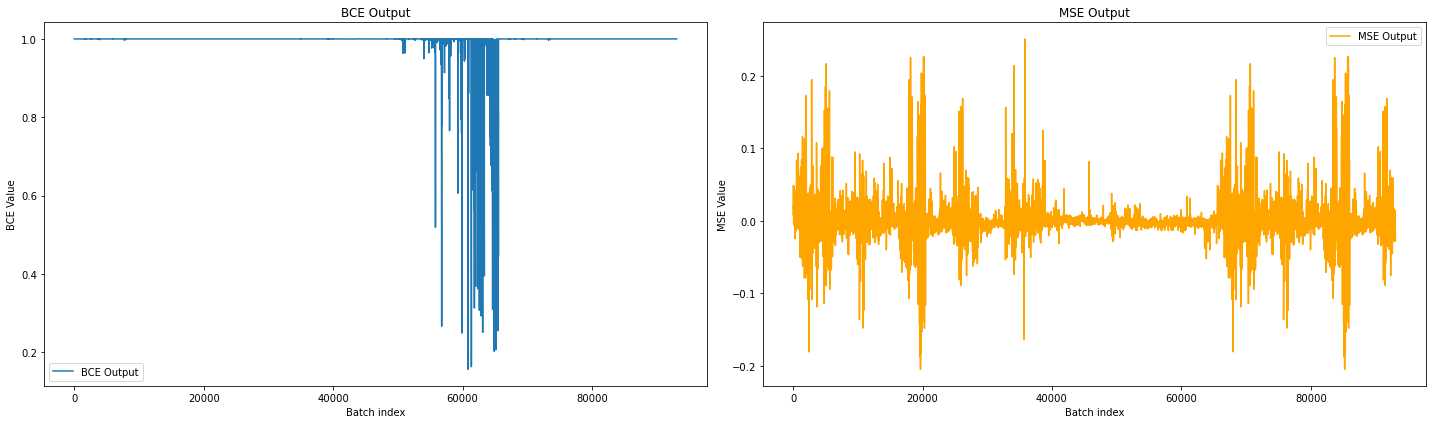

In [95]:
import matplotlib.pyplot as plt




# Create a figure and plot both outputs
plt.figure(figsize=(20, 6))

# Plot BCE outputs
plt.subplot(1, 2, 1)
plt.plot(bce_outputs.numpy(), label='BCE Output')
plt.title('BCE Output')
plt.xlabel('Batch index')
plt.ylabel('BCE Value')
plt.legend()

# Plot MSE outputs
plt.subplot(1, 2, 2)
plt.plot(mse_outputs.numpy(), label='MSE Output', color='orange')
plt.title('MSE Output')
plt.xlabel('Batch index')
plt.ylabel('MSE Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [96]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(mse_outputs, "test_mult_first_bad.wav",sample_rate)

Saved as test_mult_first_bad.wav


In [97]:
from IPython.display import Audio

# Play the .wav file
Audio("test_mult_first_bad.wav")

In [ ]:
in seq embedding, you need the individual file again.  it needs its own embedding at that layer too!!

In [ ]:
#the forward for eval is not super efficient, we only need to run the seq stuff once.  idk.  not super important right now.  


In [ ]:
time "embedding"  pass the t through a layer before you concatenat? not a bad idea

add depth to the bce and mse stuff. 

add time varying encoder part

train longer.  

the trainer should show like, averages.  lets do that before putting it on scc.  get a better idea of what is happening.

